In [1]:
import argparse

import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from lateral_connections import LateralModel, VggModel
from lateral_connections import VggWithLCL
from lateral_connections import MNISTCDataset
from lateral_connections.loaders import get_loaders, load_mnistc
from lateral_connections.character_models import SmallVggWithLCL, VGGReconstructionLCL
from lateral_connections.torch_utils import *

import datetime

In [67]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
vggonly_modelpath = 'models/vgg_with_lcl/VGG19_2022-04-04_183636__it16250_e3.pt'
vgg19r_lcl5_modelpath = 'models/vgg_reconstructed_lcl/2022-04-24_004459_LCL5_d2__it23750_e4.pt'

config = {
    'vggonly': {
        'num_classes': 10,
        'learning_rate': 1e-3,
        'dropout': 0.2,
        'num_epochs': 4,
        'batch_size': 10,
        'use_lcl': True,
        'num_multiplex': 4,
        'lcl_alpha': 1e-3,
        'lcl_theta': 0.2,
        'lcl_eta': 0.0,
        'lcl_iota': 0.2
    },
    'vgg19r_lcl5': {
        'num_classes': 10,
        'learning_rate': 1e-4,
        'num_multiplex': 4,
        'batch_size': 10,
        'num_epochs': 5,
        'lcl_alpha': 3e-4,
        'lcl_eta': 0.01,
        'lcl_theta': 0.2,
        'lcl_iota': 0.2,
        'lcl_distance': 2,
        'lcl_k': 5,
        'after_pooling': 5
    }
}

def load_vgg19r_lcl5(config, model_path):
    # Only load to initialize reconstruction
    vgg = VggWithLCL(config['num_classes'], learning_rate=3e-4, dropout=0.2)
    # generate & load weights for reconstructed model
    model = VGGReconstructionLCL(vgg,
                                 learning_rate=config['learning_rate'],
                                 after_pooling=config['after_pooling'],
                                 num_multiplex=config['num_multiplex'],
                                 run_identifier='',
                                 lcl_distance=config['lcl_distance'],
                                 lcl_alpha=config['lcl_alpha'],
                                 lcl_eta=config['lcl_eta'],
                                 lcl_theta=config['lcl_theta'],
                                 lcl_iota=config['lcl_iota'])
    model.load(model_path)
    model.features.lcl.enable()
    del vgg
    return model

def load_vgg19(config, model_path):
    model = VggWithLCL(config['num_classes'], \
                       learning_rate=config['learning_rate'], \
                       dropout=config['dropout'], \
                       num_multiplex=config['num_multiplex'], \
                       do_wandb=False, \
                       run_identifier="", \
                       lcl_alpha=config['lcl_alpha'], \
                       lcl_eta=config['lcl_eta'], \
                       lcl_theta=config['lcl_theta'], \
                       lcl_iota=config['lcl_iota'])
    model.load(model_path)
    return model

#vgg19 = load_vgg19(config['vggonly'], vggonly_modelpath)
#vgg19

model = load_vgg19r_lcl5(config['vgg19r_lcl5'], vgg19r_lcl5_modelpath)
model

VGGReconstructionLCL(
  (features): Sequential(
    (vgg19_unit): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(i

In [3]:
from pytorch_patternnet.networks import PatternNet
from collections import OrderedDict

cpu_device = torch.device('cpu')

dataset_identity = load_mnistc(dirname='identity')
dataset_line = load_mnistc(dirname='line')

In [4]:
def run_through_lcl(model, img):
    img = img.unsqueeze(0).to(torch.device('cuda'))
    img_processed = model.features(img)
    
    if type(model) == VGGReconstructionLCL:
        img_processed = model.maxpool(img_processed)
    else:
        img_processed = model.avgpool(img_processed)
    
    img_processed = torch.flatten(img_processed, 1)
    img_processed = img_processed.to(torch.device('cpu'))
    return img_processed

def plot_dominating_gradient(model, pn, img, k=10, plot_title=None):
    signals = pn(run_through_lcl(model, img))
    signals = signals.reshape((512,7,7))
    vals, inds = torch.topk(torch.sum(signals, dim=(-2,-1)), k)
    
    fig, axs = plt.subplots(1, 2, figsize=(9,4))
    if plot_title:
        plt.suptitle(plot_title)
    
    axs[0].imshow(torch.sum(signals[inds], dim=0).detach(), vmin=0)
    axs[1].imshow(img.transpose(1,2).transpose(0,2).detach(), vmin=0)
    
    plt.tight_layout()
    plt.show()

In [5]:
pn = PatternNet(model.classifier)
pn.to(cpu_device)
pn

for i in tqdm(range(15)):
    img, label = dataset_identity[i]
    pn.compute_statistics(run_through_lcl(model, img))
    
pn.compute_patterns()
pn.set_patterns()

  0%|          | 0/15 [00:00<?, ?it/s]

In [6]:
vgg19 = load_vgg19(config['vggonly'], vggonly_modelpath)
vgg19

pn_vgg = PatternNet(model.classifier)
pn_vgg.to(cpu_device)

for i in tqdm(range(15)):
    img, label = dataset_identity[i]
    pn_vgg.compute_statistics(run_through_lcl(vgg19, img))
    
pn_vgg.compute_patterns()
pn_vgg.set_patterns()

  0%|          | 0/15 [00:00<?, ?it/s]

### Check which images were wrongly predicted

In [40]:
df_vgg_id = pd.read_csv('mnist_c__identity__vggonly__predictions.csv')
df_vgg_id = df_vgg_id[df_vgg_id.columns[1:]]
df_vgg_line = pd.read_csv('mnist_c__line__vggonly__predictions.csv')
df_lcl_id = pd.read_csv('mnist_c__identity__vgg19r_lcl5__predictions.csv')
df_lcl_line = pd.read_csv('mnist_c__line__vgg19r_lcl5__predictions.csv')

df_vgg = df_vgg_id.join(df_vgg_line[['prediction']], how='inner', rsuffix='_line')
df_lcl = df_lcl_id.join(df_lcl_line[['prediction']], how='inner', rsuffix='_line')


df = df_vgg[['label','prediction','prediction_line']].join(df_lcl[['label','prediction','prediction_line']], how='inner', lsuffix='__vgg', rsuffix='__lcl')
df[df['prediction__vgg'] == df['label__vgg']][df['prediction_line__vgg'] != df['label__vgg']][df['prediction_line__lcl'] == df['label__lcl']]


/tmp/ipykernel_3390/22194239.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['prediction__vgg'] == df['label__vgg']][df['prediction_line__vgg'] != df['label__vgg']][df['prediction_line__lcl'] == df['label__lcl']]


,label__vgg,prediction__vgg,prediction_line__vgg,label__lcl,prediction__lcl,prediction_line__lcl
7,9,9,5,9,9,9
14,1,1,8,1,1,1
33,4,4,5,4,4,4
37,1,1,7,1,1,1
40,1,1,7,1,1,1
...,...,...,...,...,...,...
9845,1,1,2,1,1,1
9856,9,9,5,9,9,9
9885,0,0,2,0,0,0
9959,8,8,1,8,8,8


/tmp/ipykernel_3390/3724103890.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  interesting_images = df[df['prediction__vgg'] == df['label__vgg']][df['prediction_line__vgg'] != df['label__vgg']][df['prediction_line__lcl'] == df['label__lcl']]


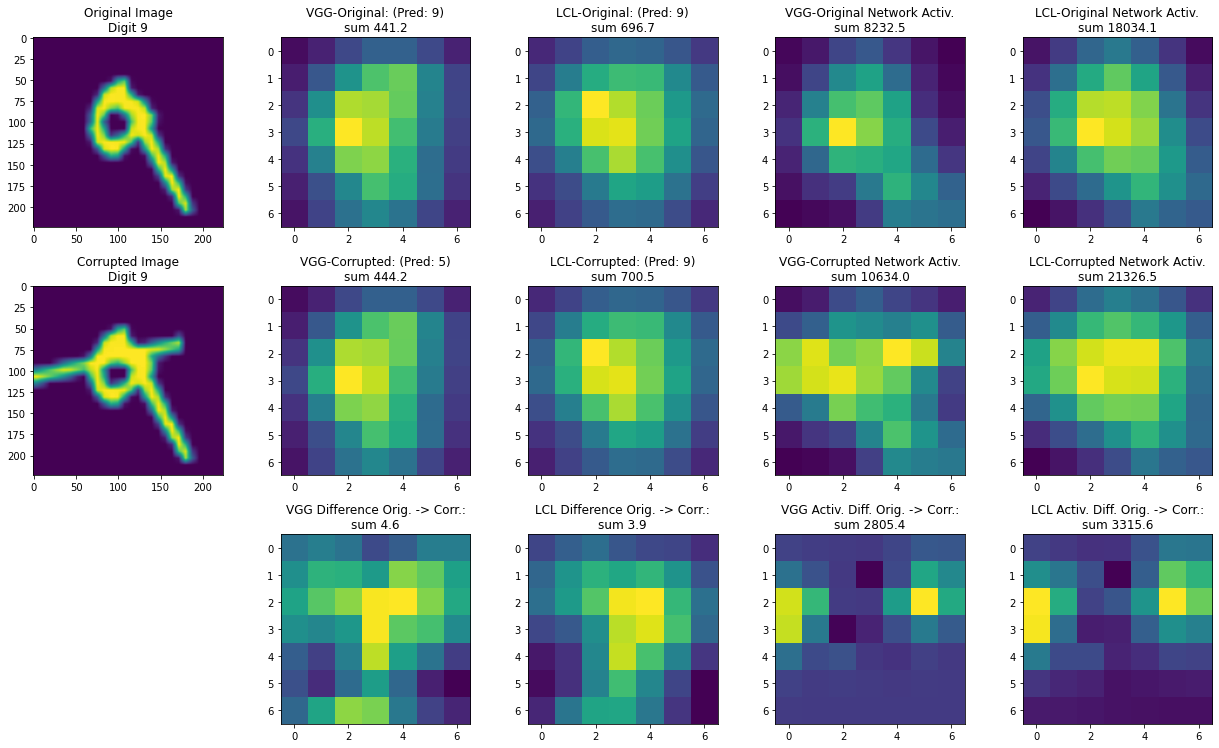

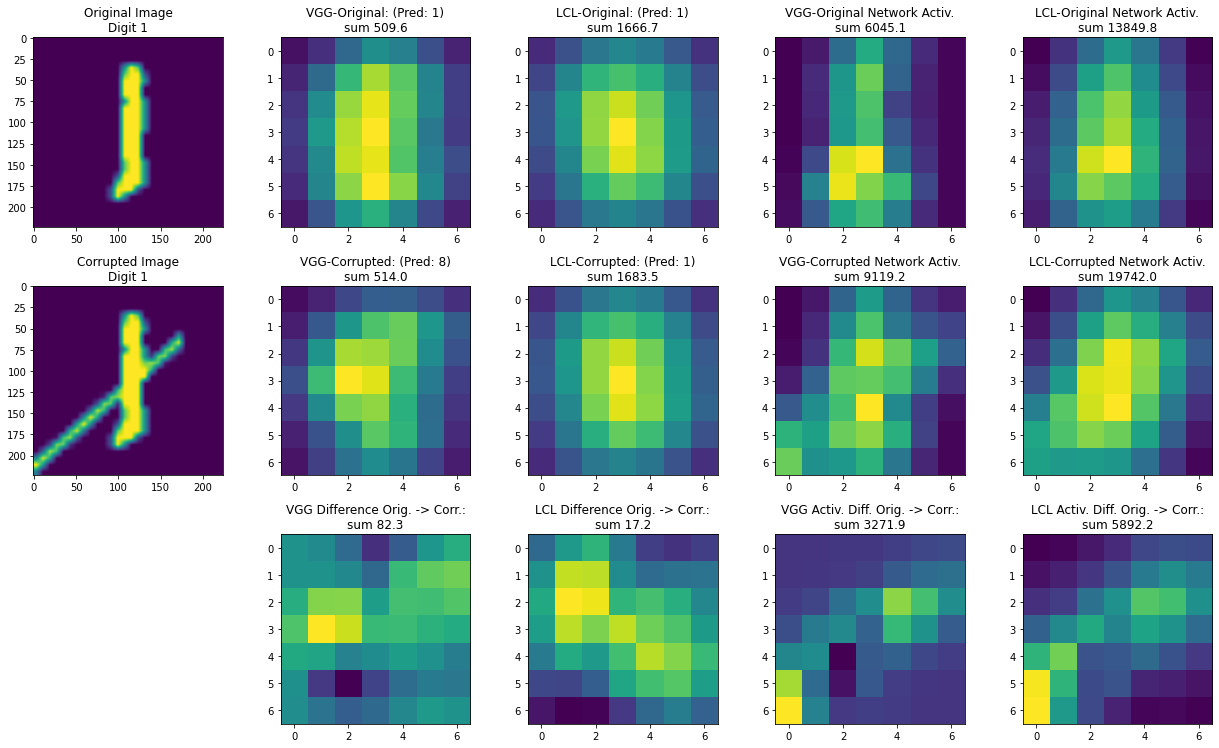

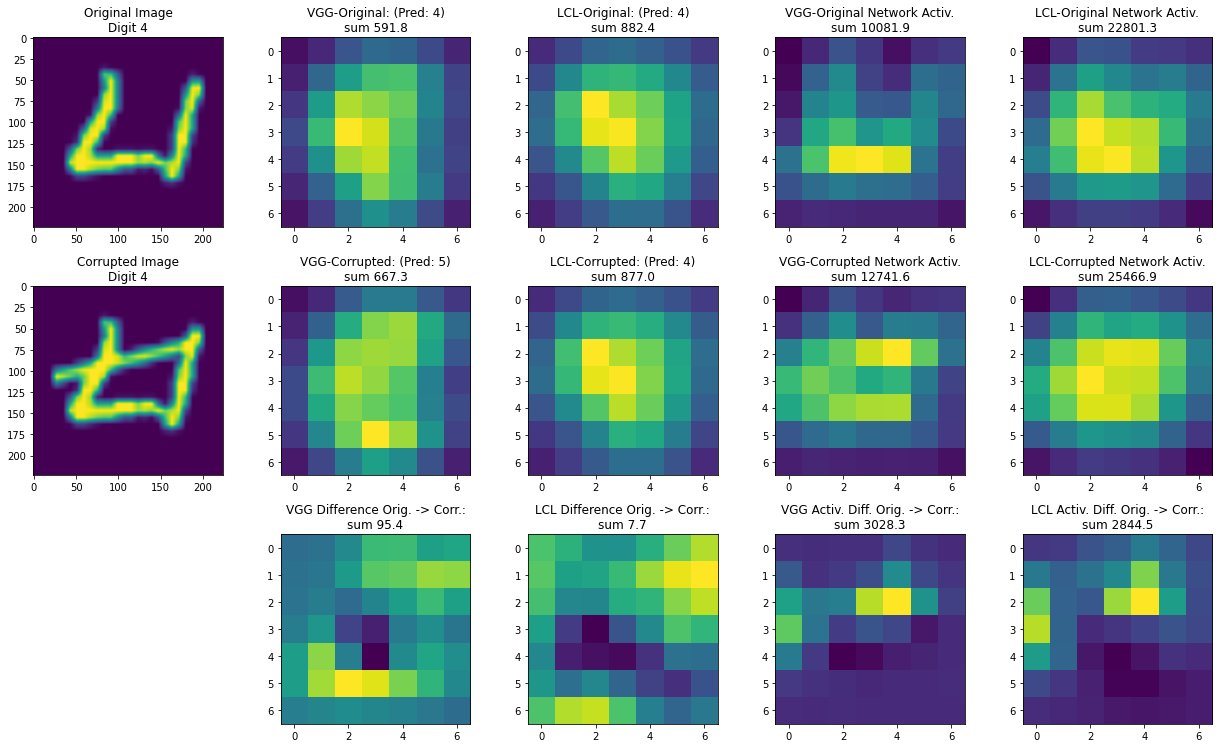

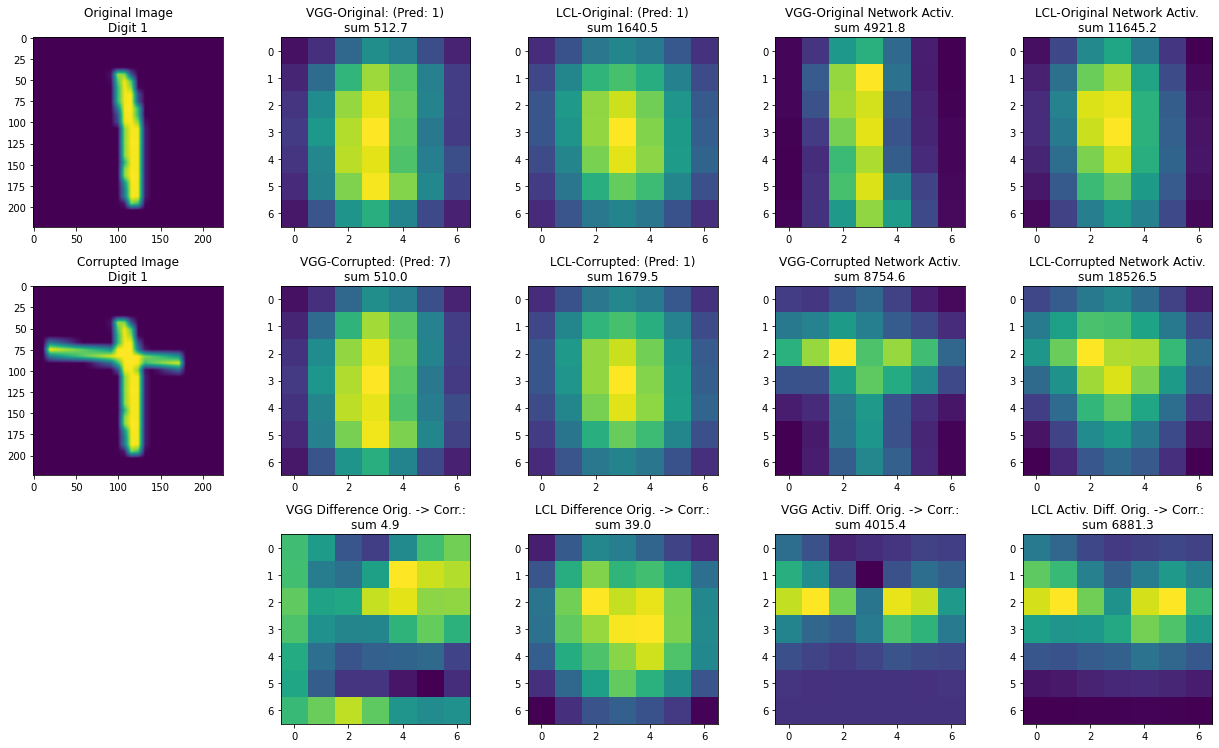

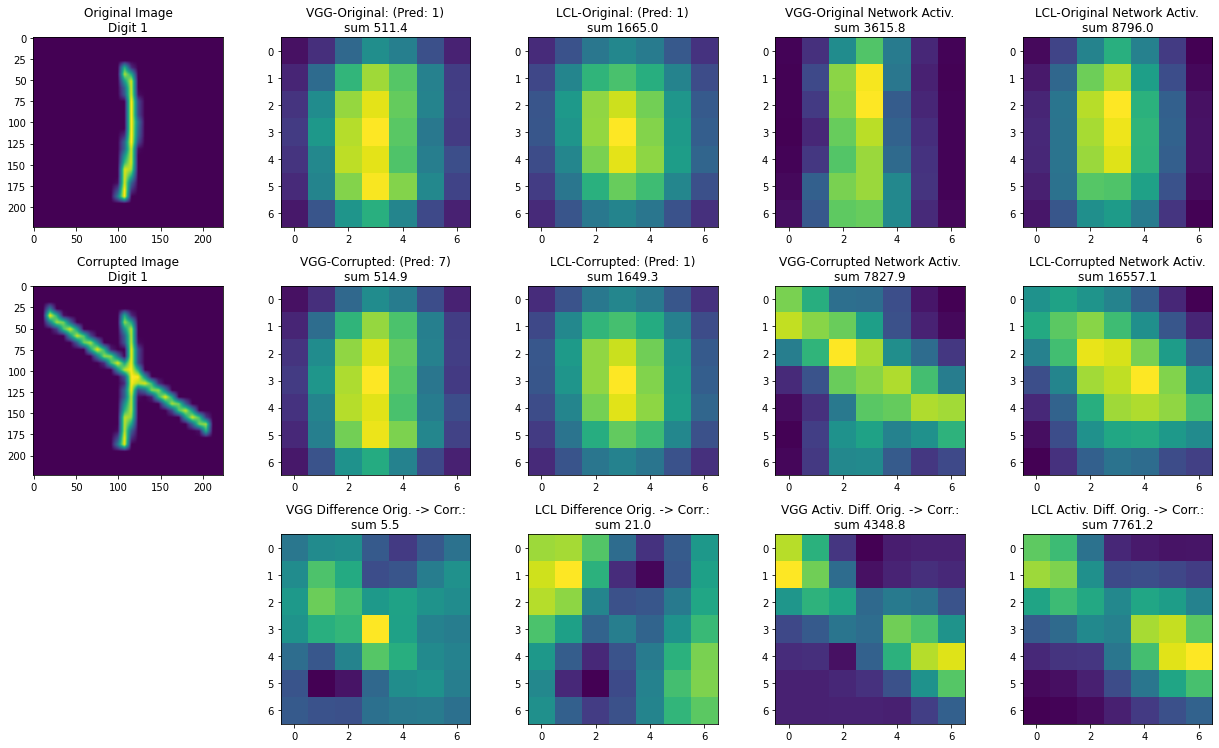

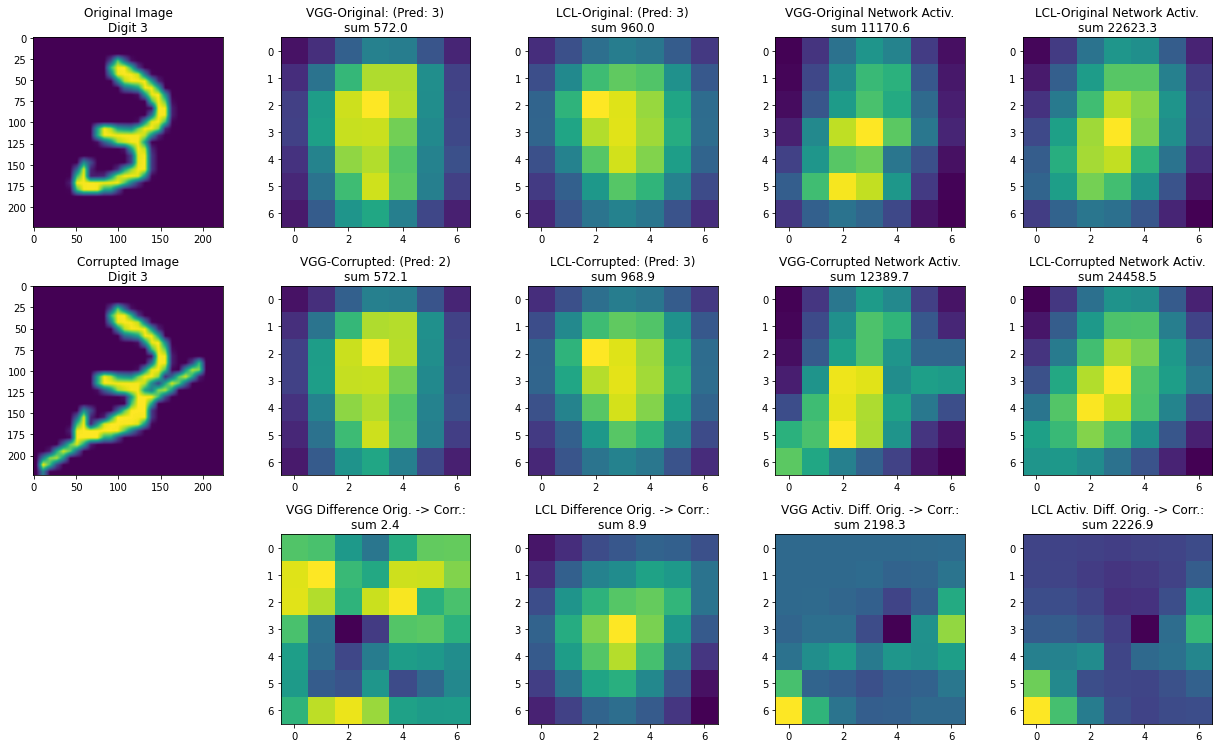

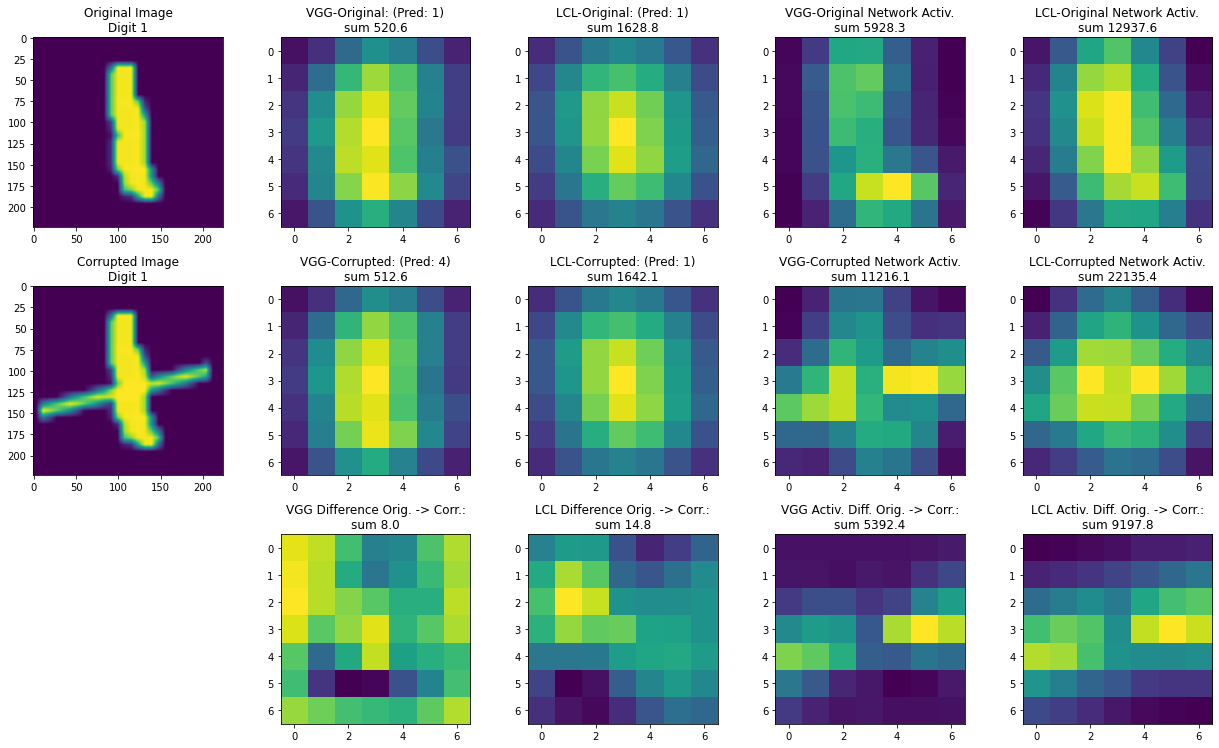

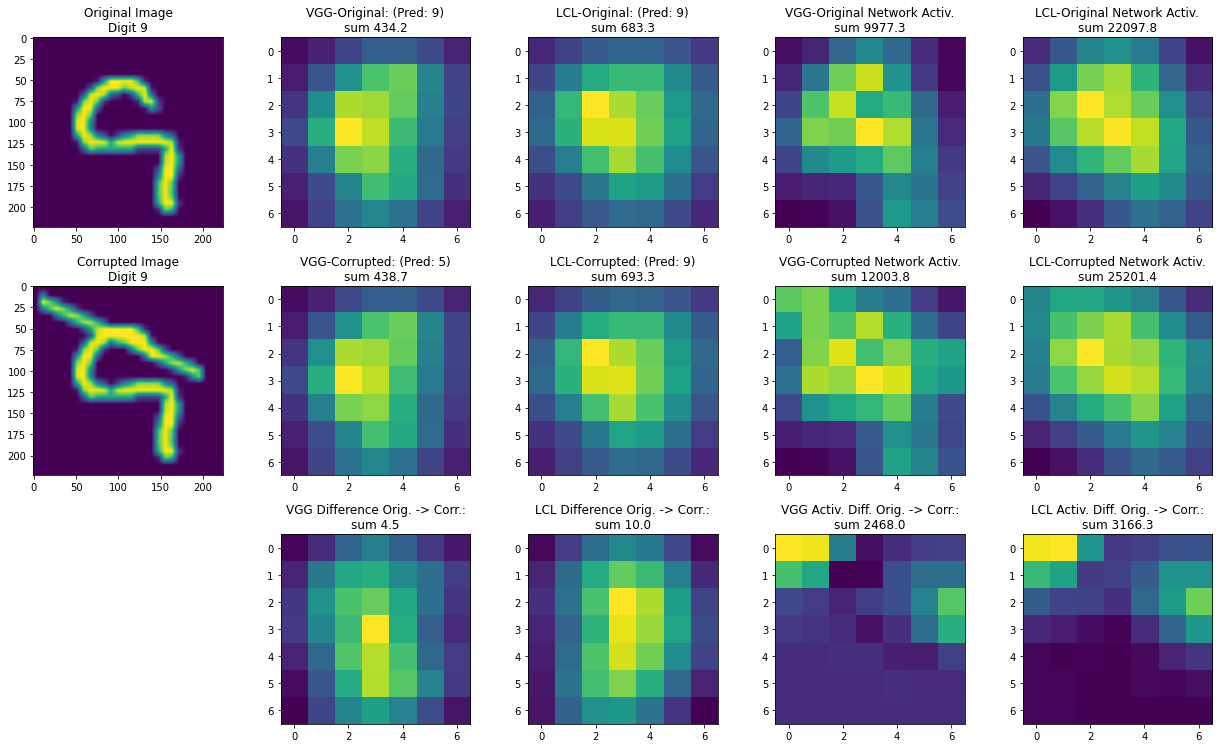

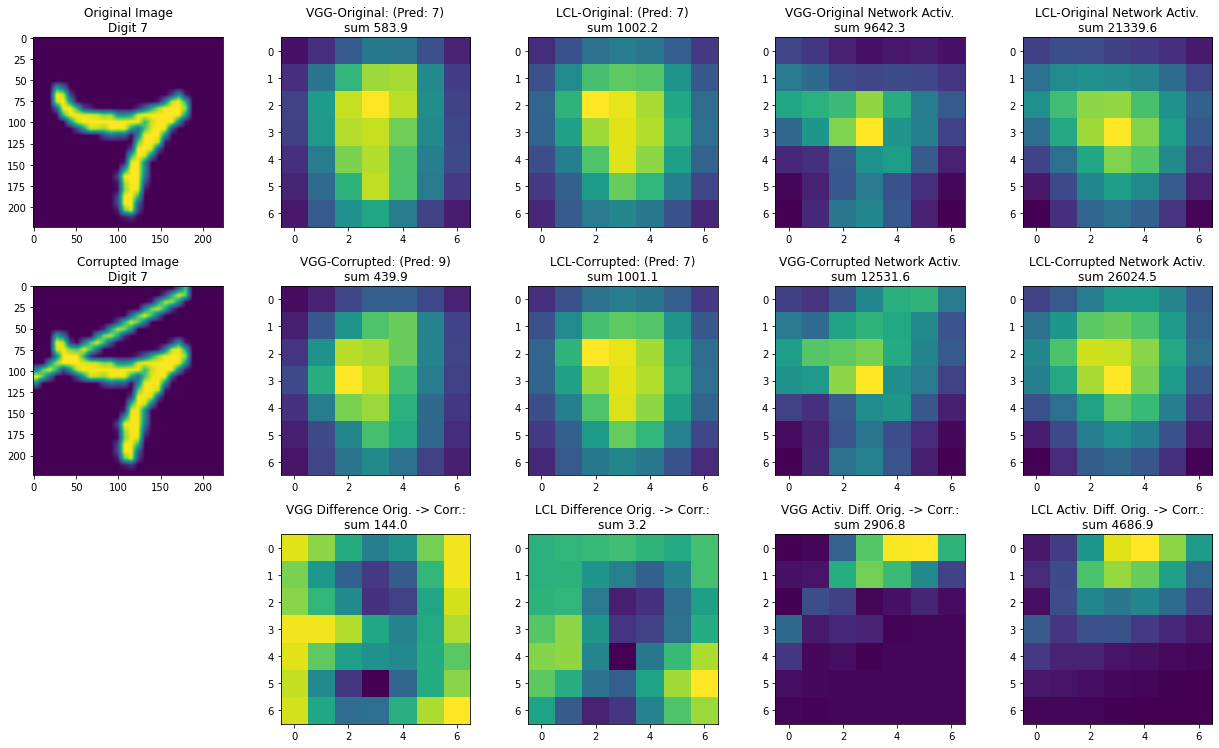

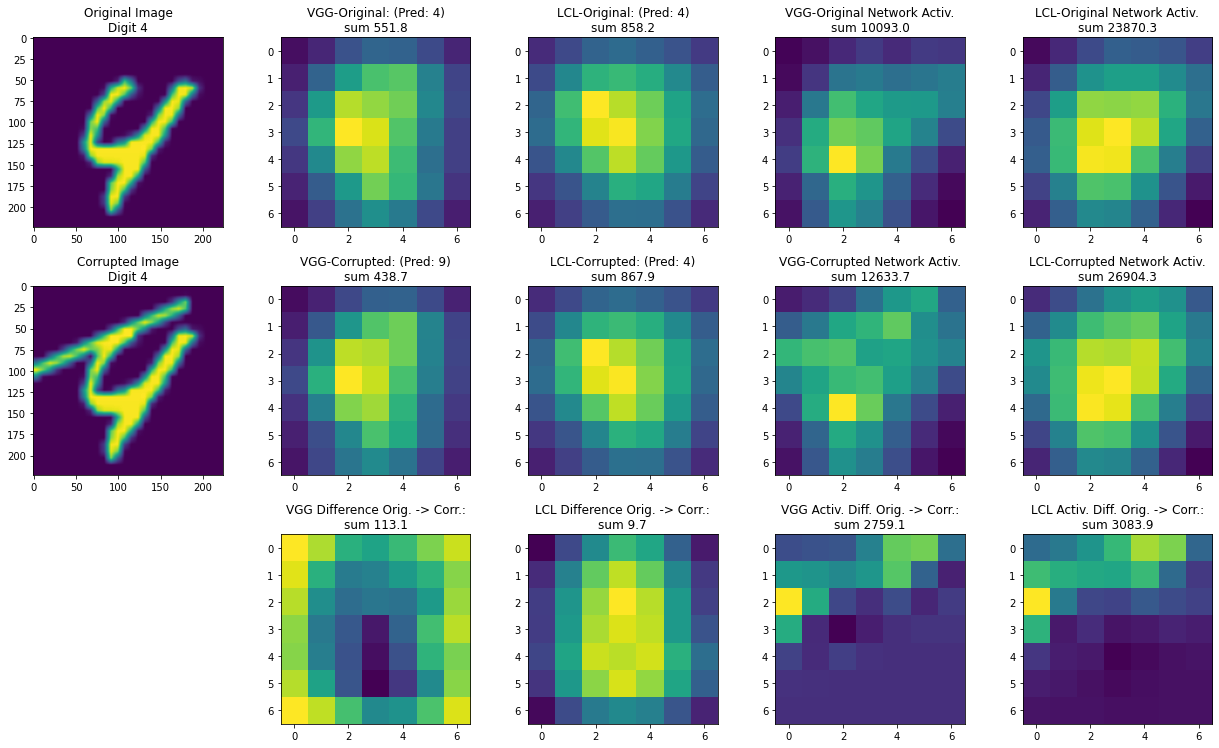

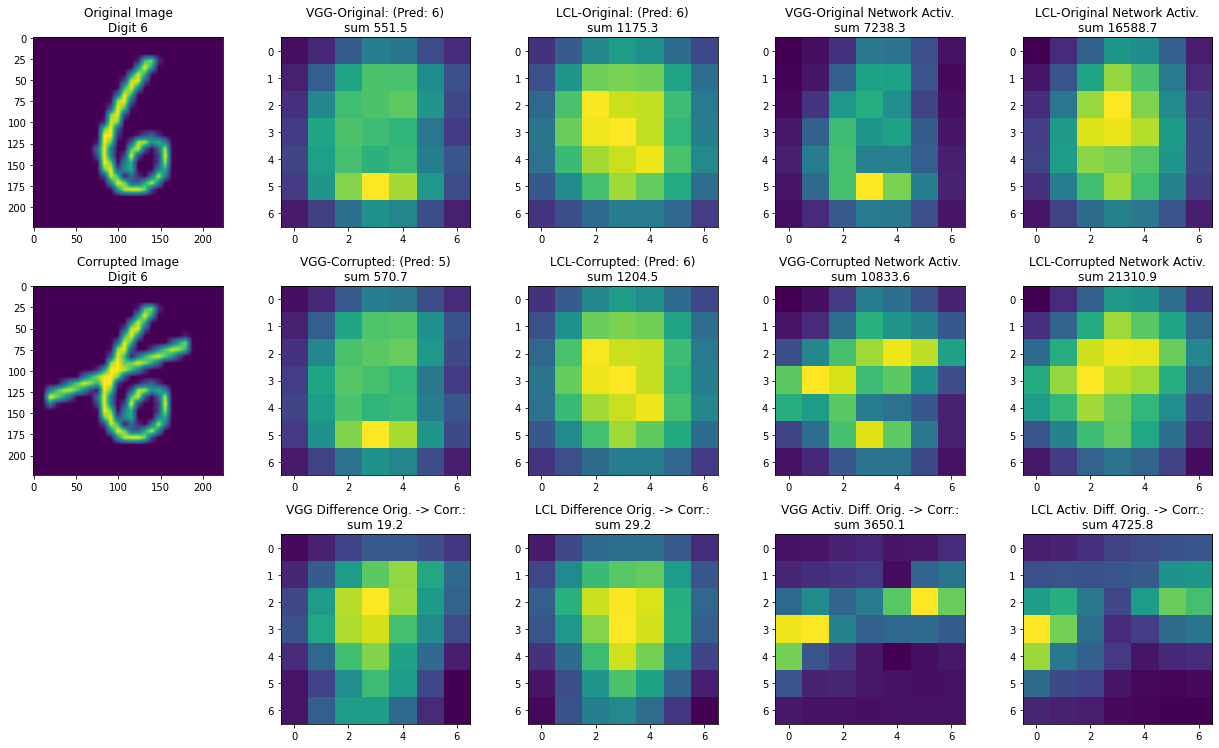

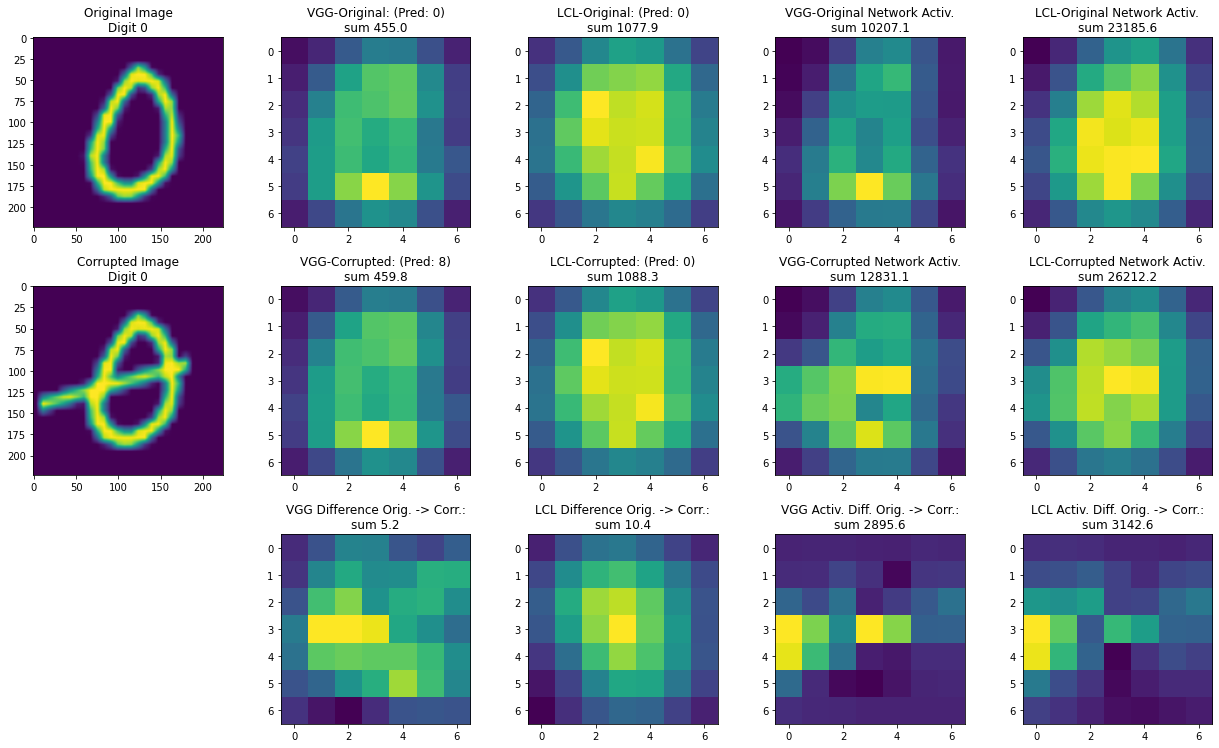

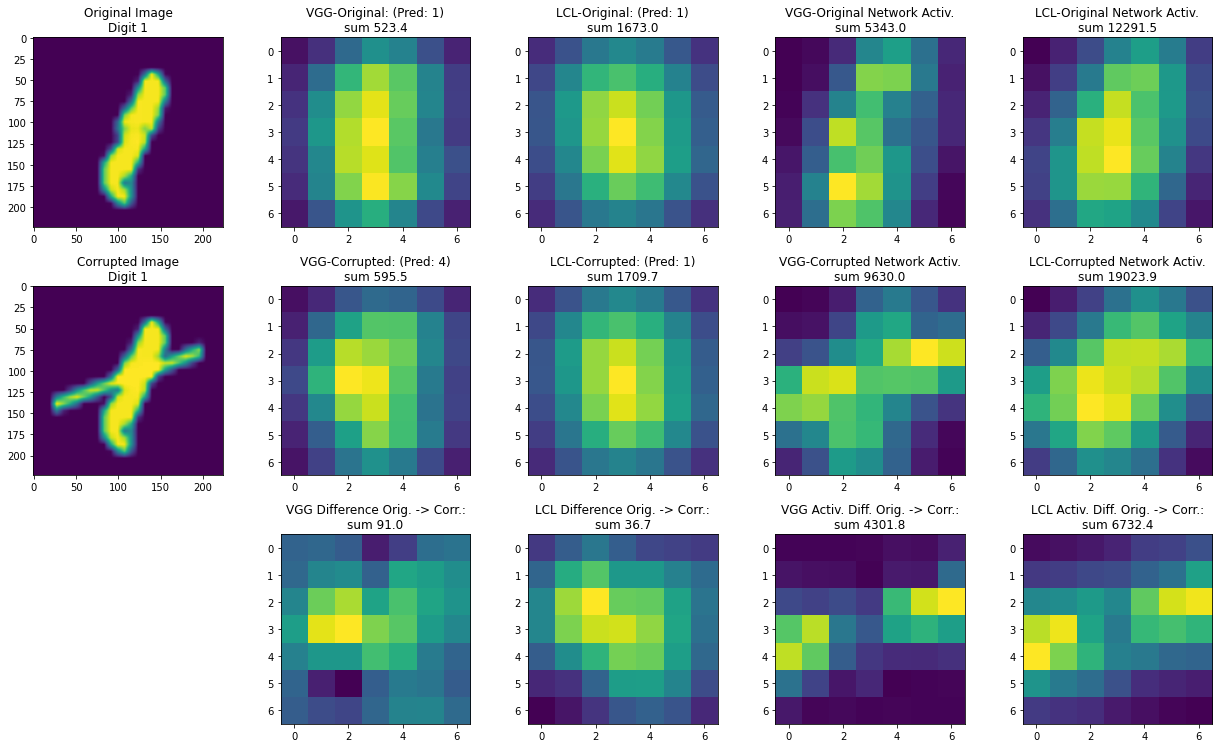

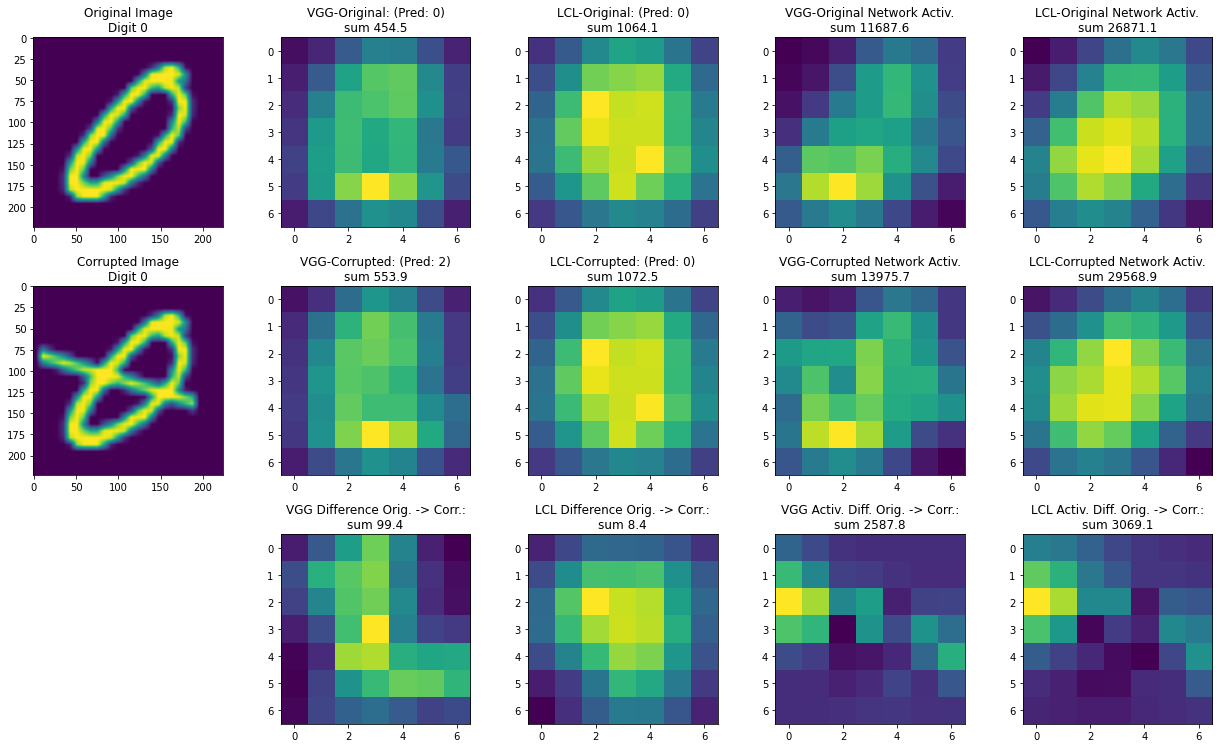

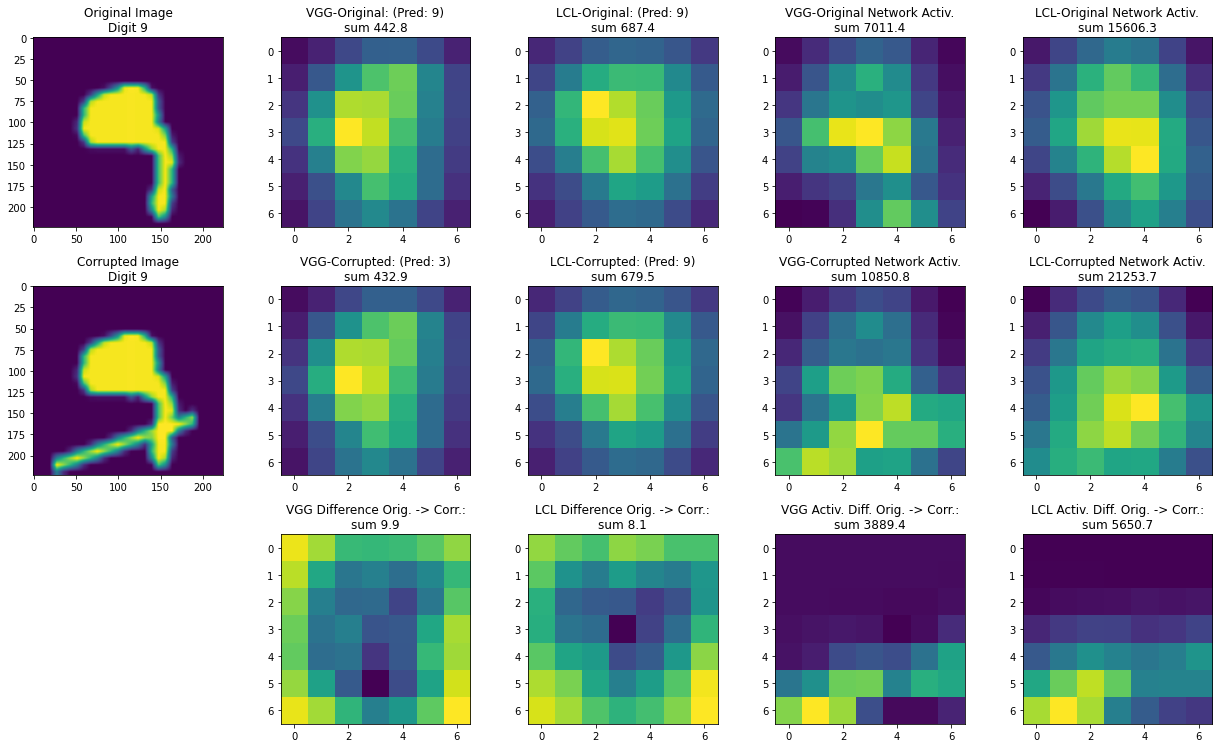

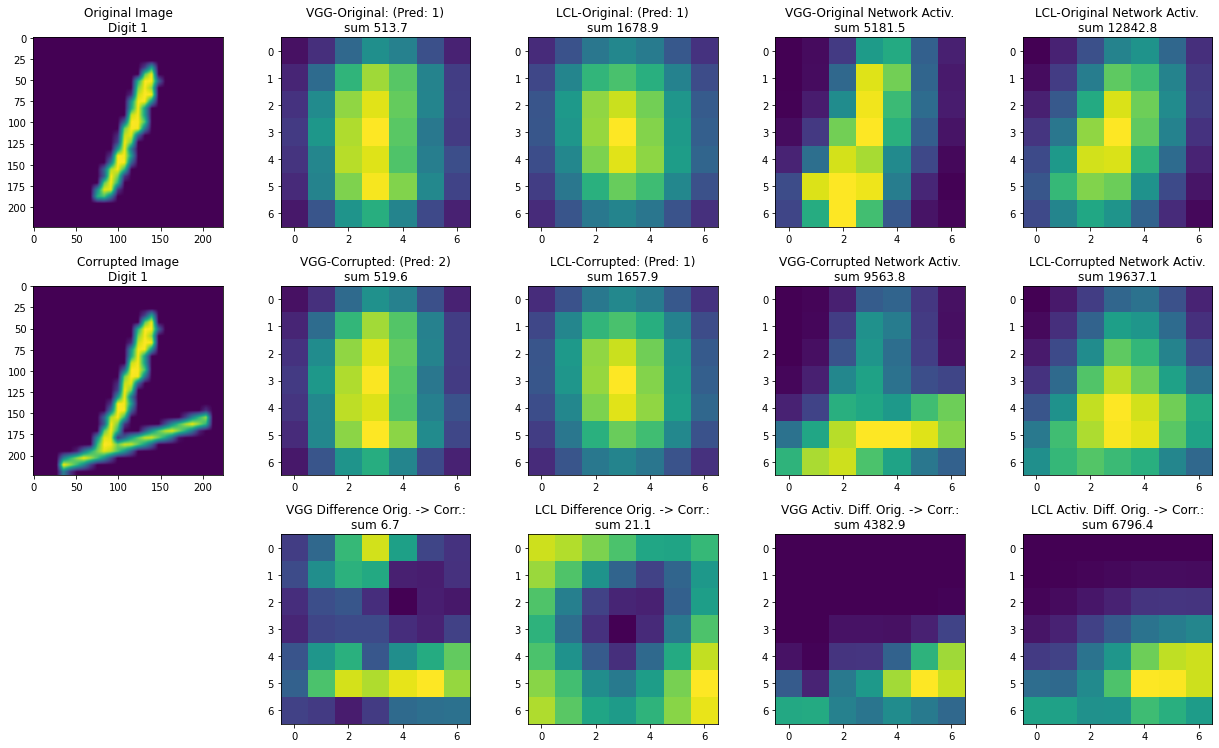

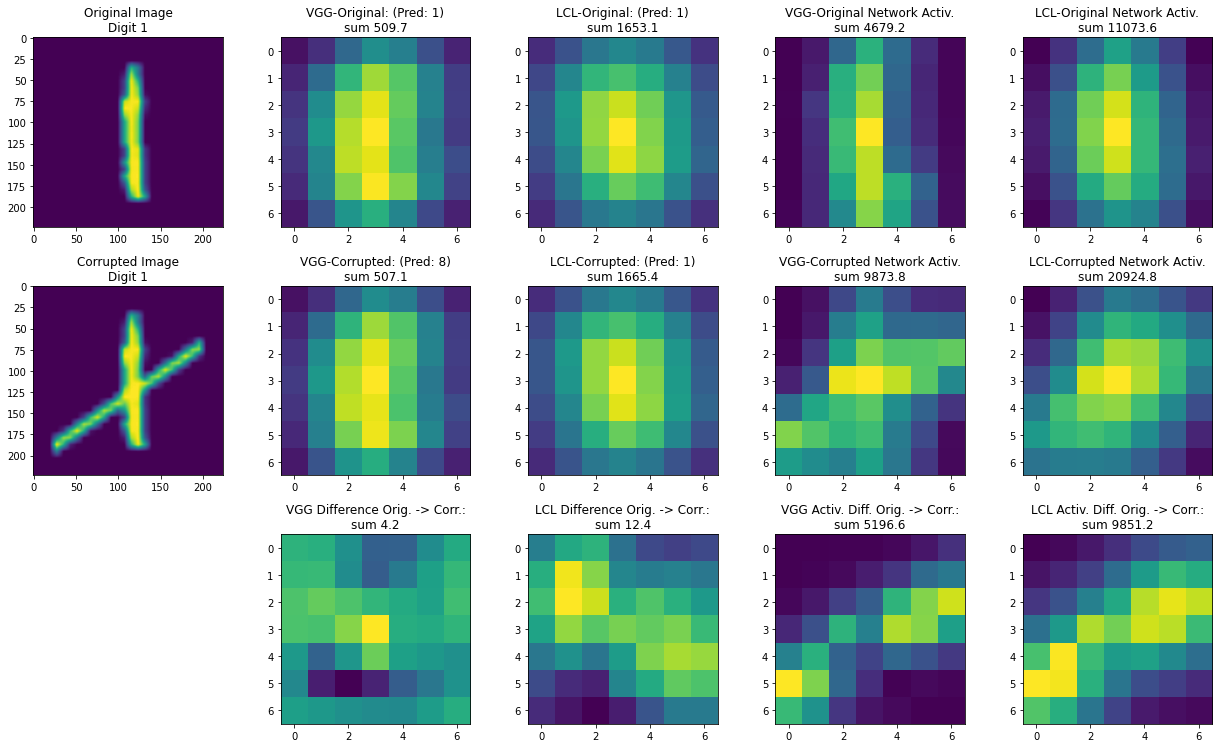

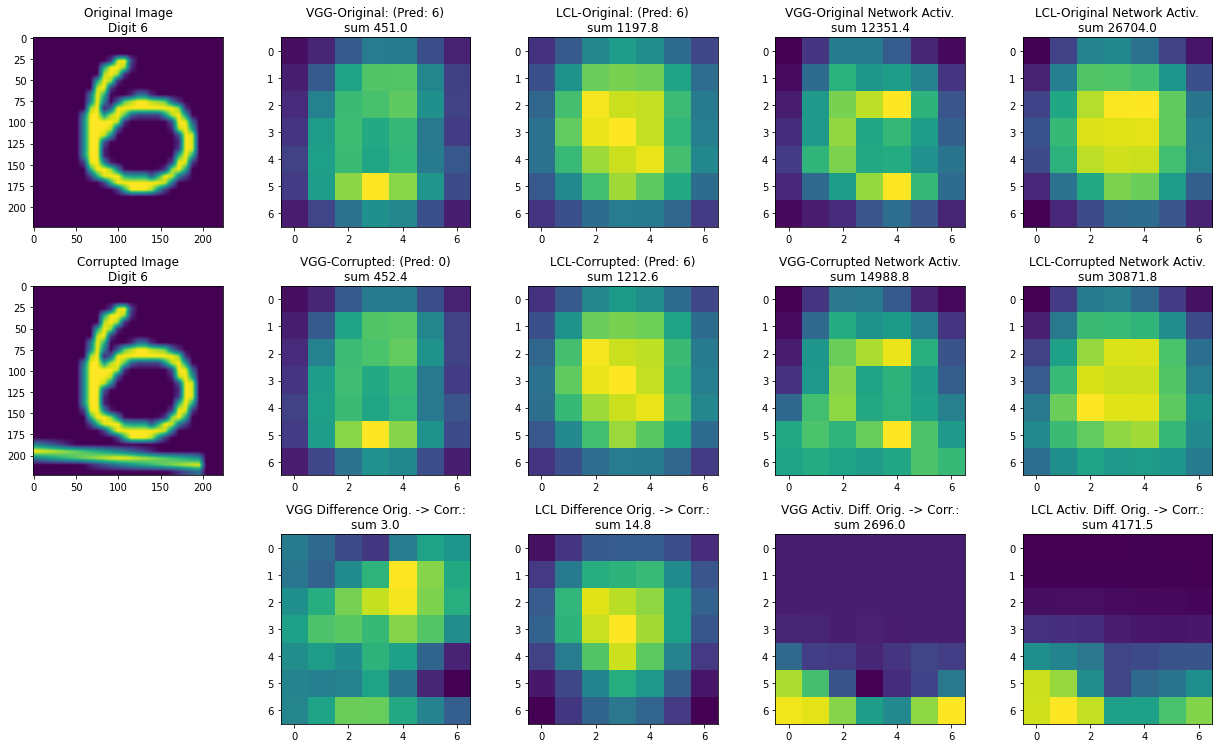

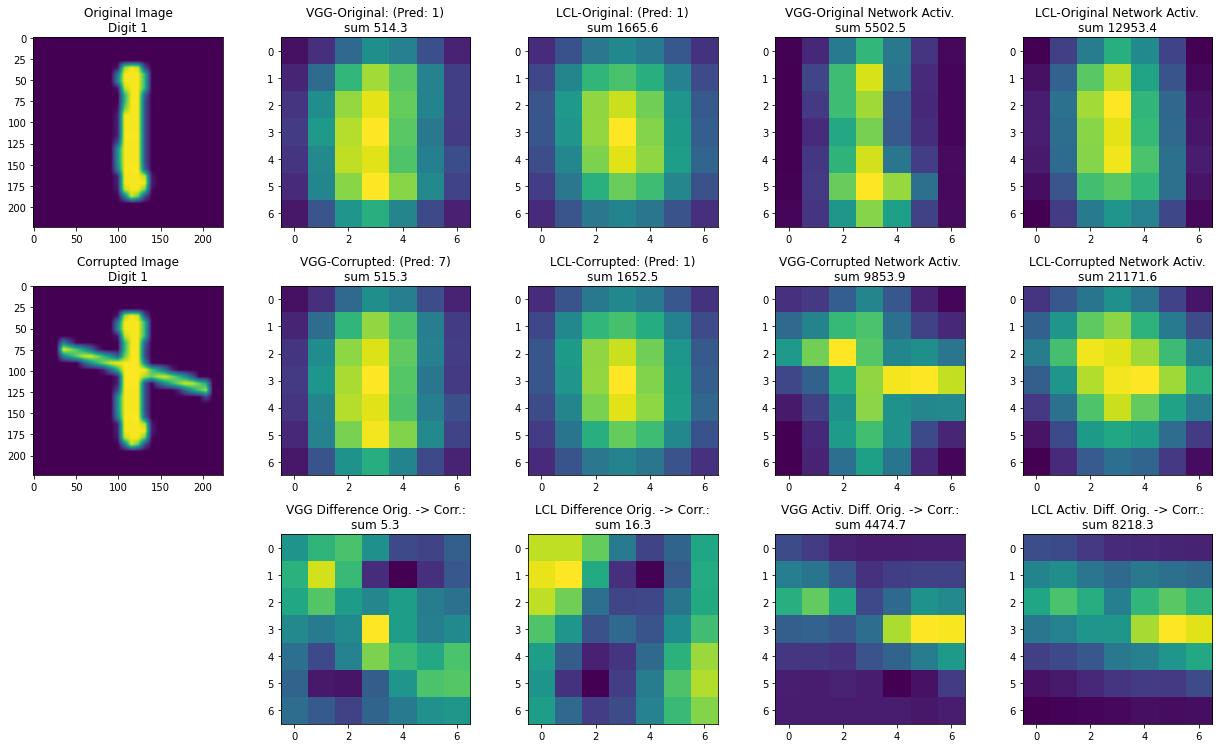

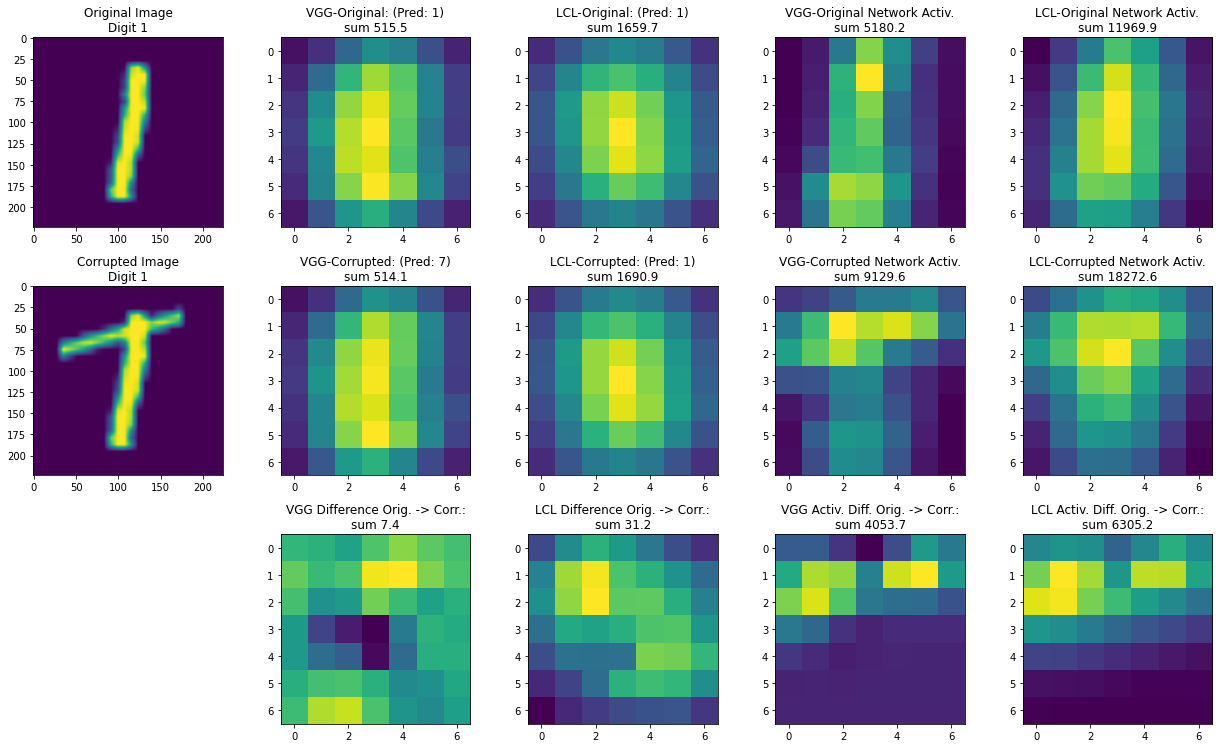

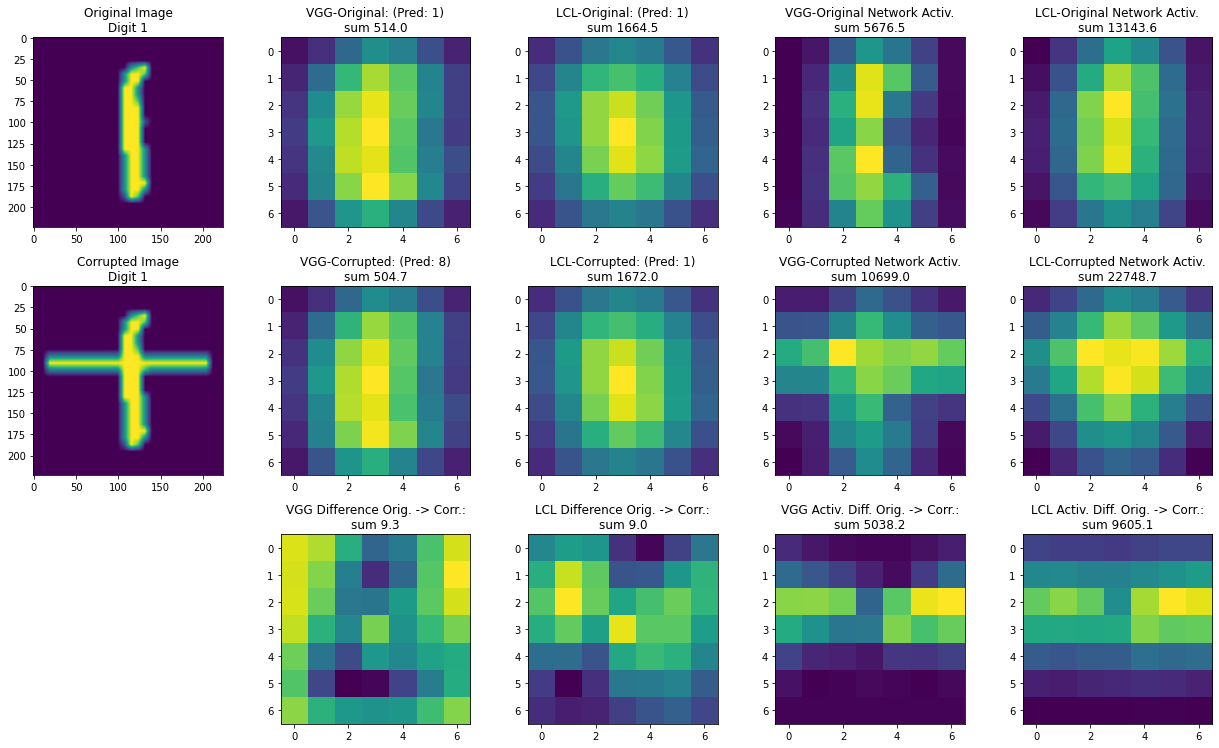

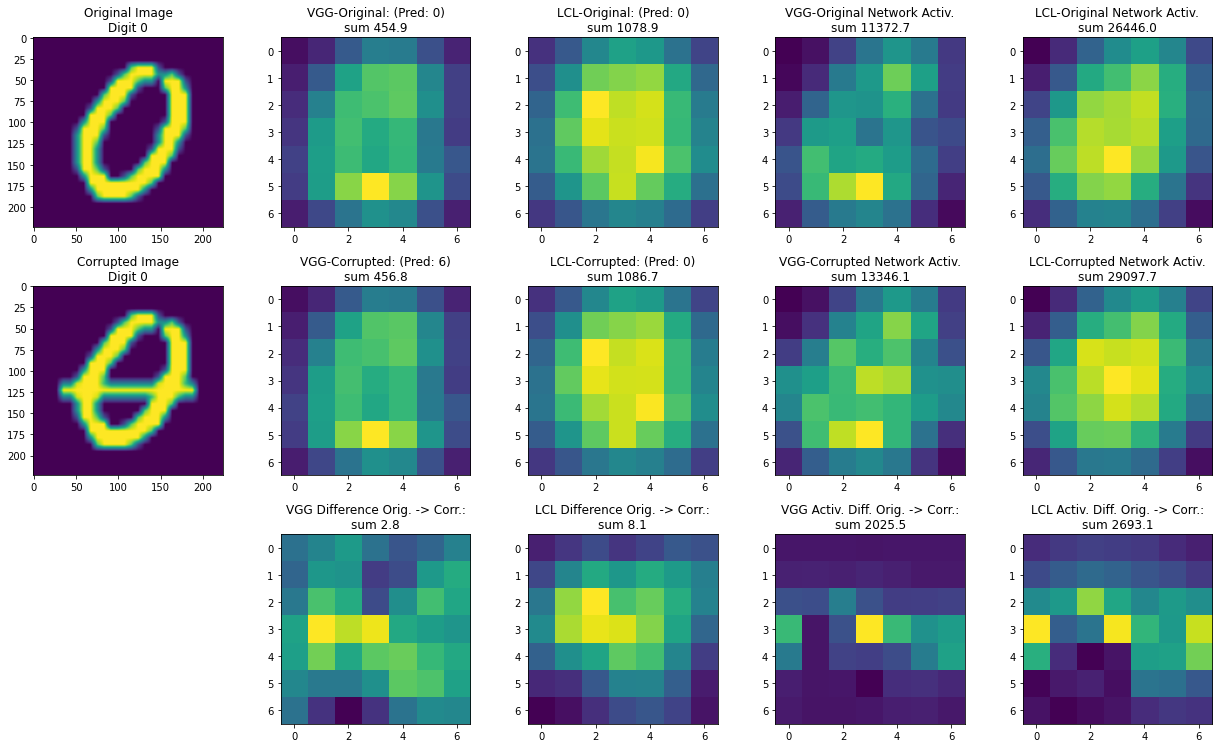

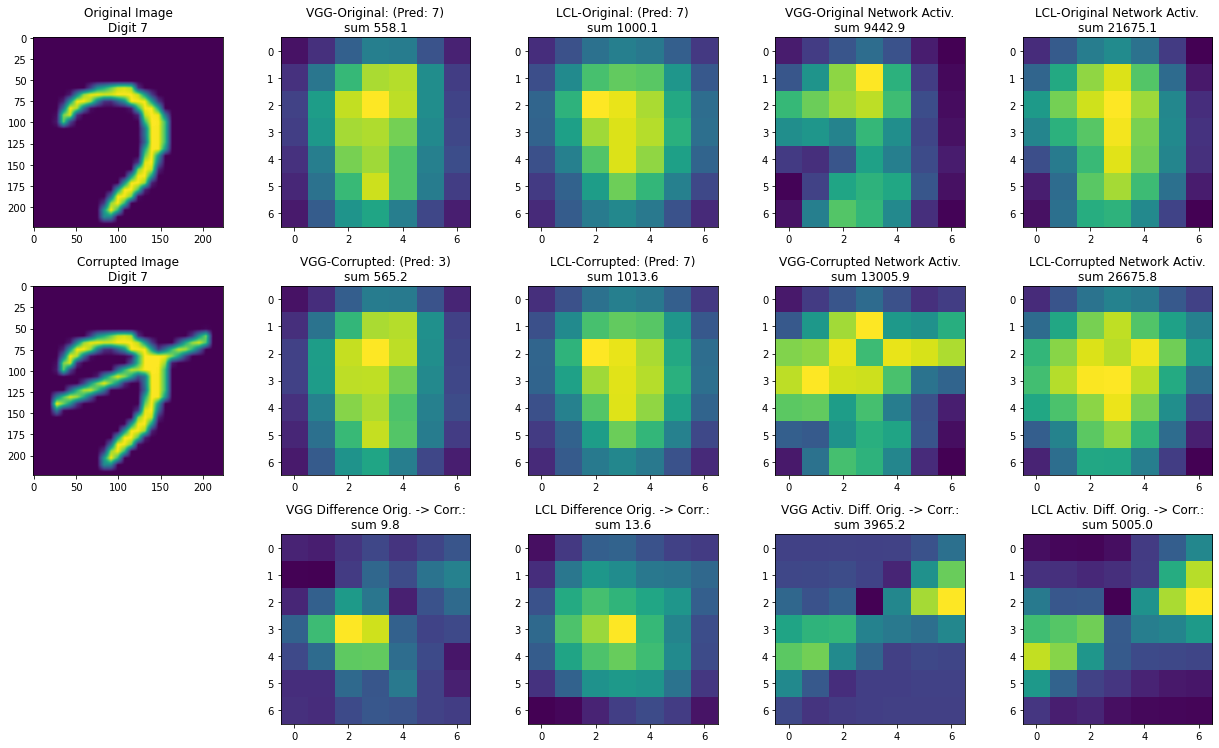

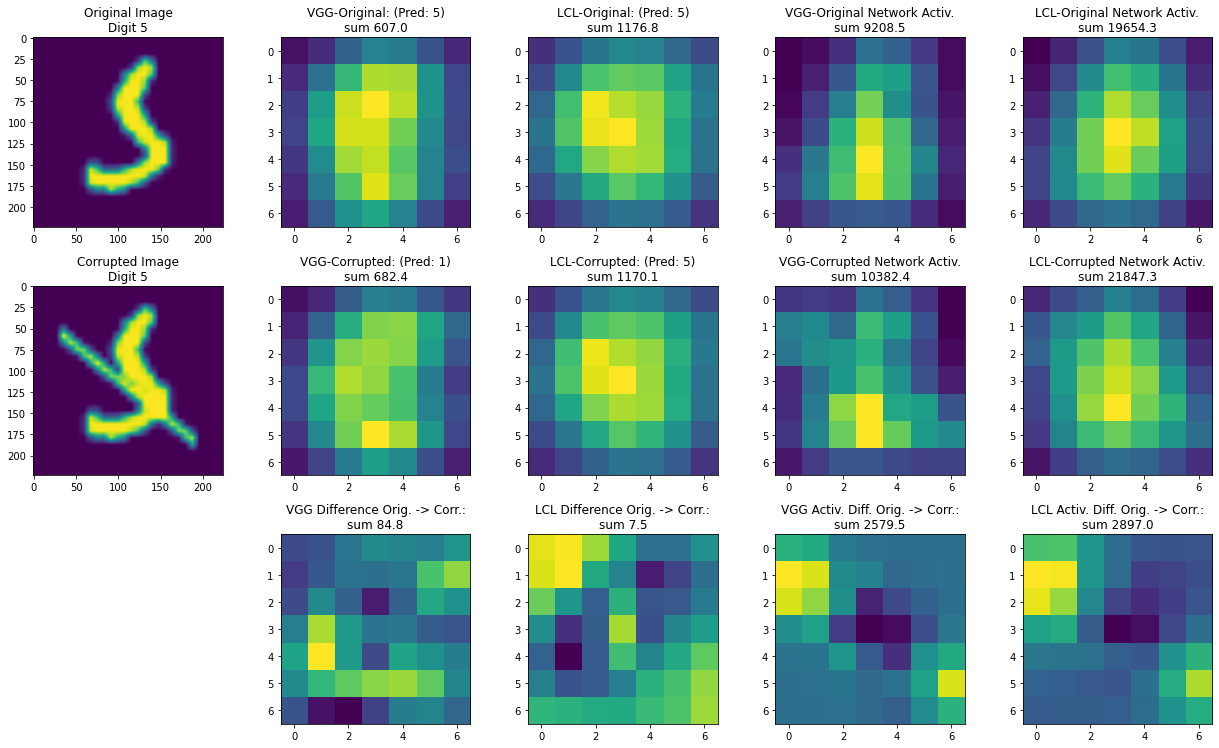

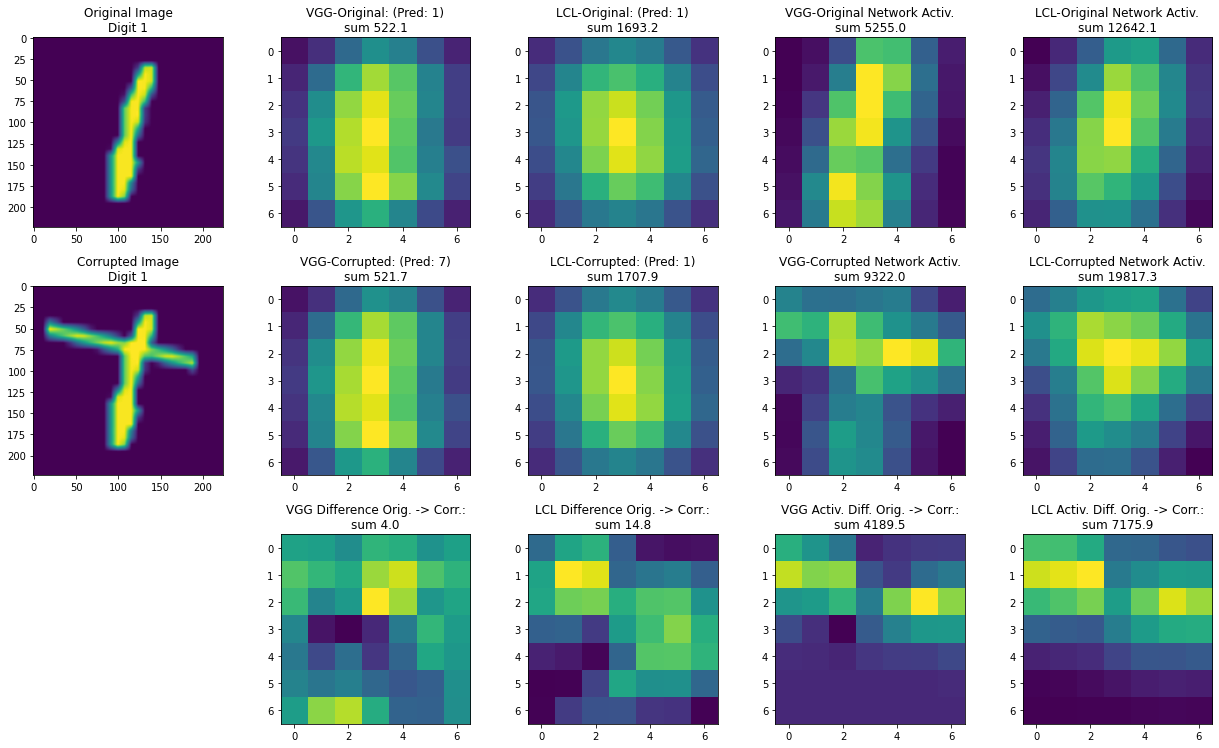

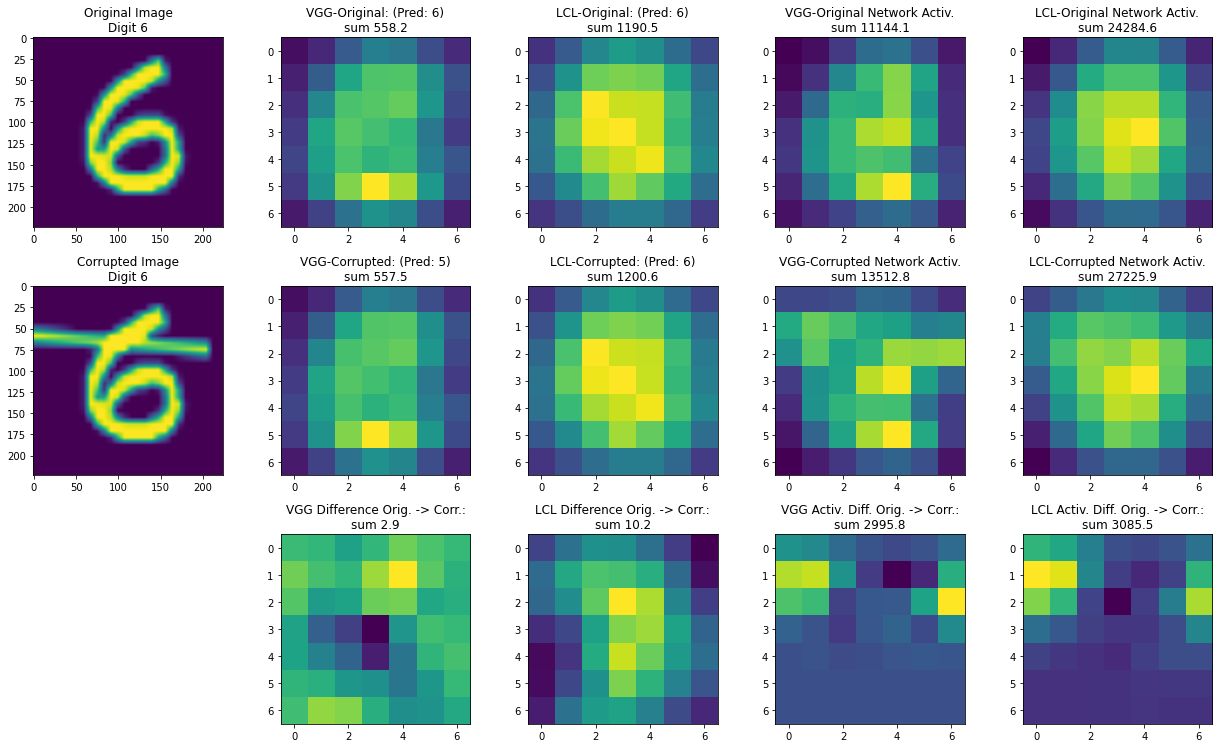

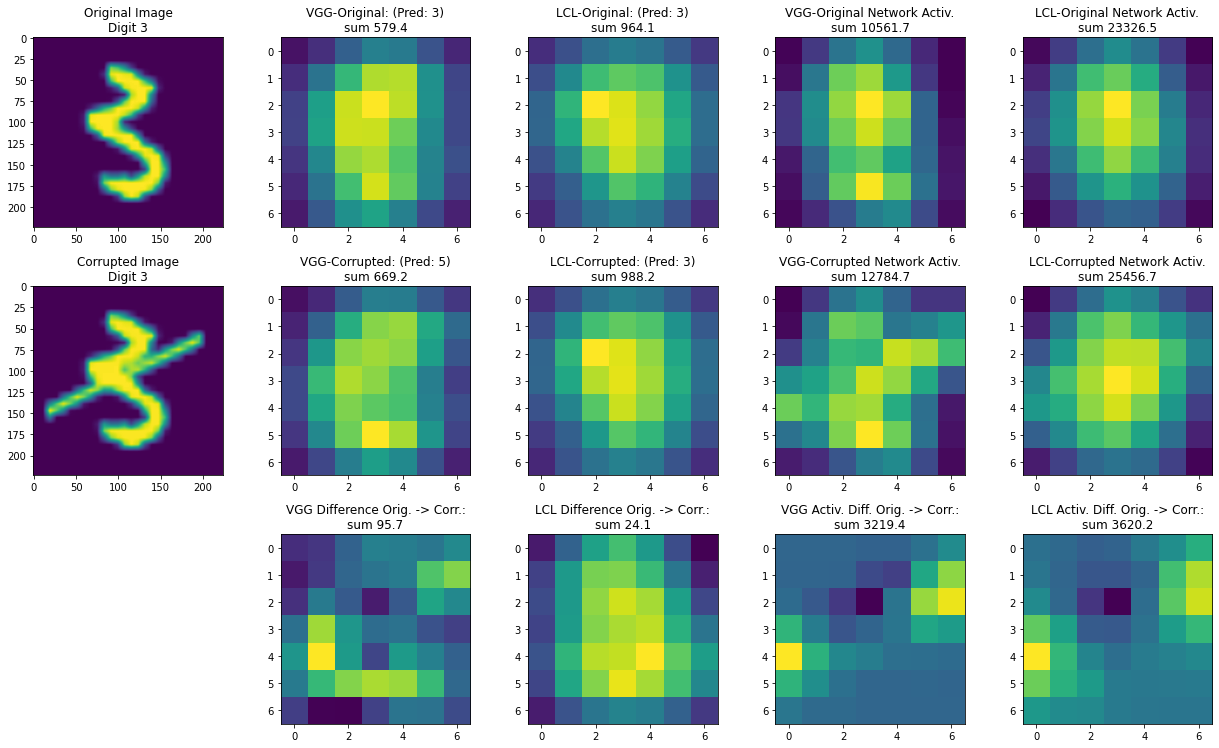

KeyboardInterrupt: 

In [74]:
#img_index = int(np.random.choice(np.arange(len(dataset_line))))
img_index = 37


plot_size = 3.5
num_rows = 3
num_cols = 5

interesting_images = df[df['prediction__vgg'] == df['label__vgg']][df['prediction_line__vgg'] != df['label__vgg']][df['prediction_line__lcl'] == df['label__lcl']]
for img_index, row in interesting_images.iterrows():
    img, label = dataset_identity[img_index]
    img_line, label_line = dataset_line[img_index]
    

    vgg_A = run_through_lcl(vgg19, img)
    signals_vgg = pn_vgg(vgg_A).reshape((512,7,7)).detach()
    
    lcl_A = run_through_lcl(model, img)
    signals_lcl = pn(lcl_A).reshape((512,7,7)).detach()

    signals_vgg__sum = torch.sum(signals_vgg, dim=0)
    signals_lcl__sum = torch.sum(signals_lcl, dim=0)

    vgg_line_A = run_through_lcl(vgg19, img_line)
    signals_line_vgg = pn_vgg(vgg_line_A).reshape((512,7,7)).detach()
    lcl_line_A = run_through_lcl(model, img_line)
    signals_line_lcl = pn(lcl_line_A).reshape((512,7,7)).detach()

    signals_line_vgg__sum = torch.sum(signals_line_vgg, dim=0)
    signals_line_lcl__sum = torch.sum(signals_line_lcl, dim=0)

    def topk_inds(signals, k=256):
        _, inds = torch.topk(torch.sum(signals, dim=(-2,-1)), k)
        return inds


    fig, axs = plt.subplots(num_rows,num_cols, figsize=(num_cols*plot_size,num_rows*plot_size))

    # Plot Images
    axs[0,0].imshow(img.transpose(1,2).transpose(0,2).cpu())
    axs[0,0].set_title('Original Image\nDigit ' + str(label.item()))
    axs[1,0].imshow(img_line.transpose(1,2).transpose(0,2).cpu())
    axs[1,0].set_title('Corrupted Image\nDigit ' + str(label_line.item()))

    # Plot Regular Signals
    vgg_val = torch.sum(signals_vgg[topk_inds(signals_vgg)], dim=0)
    axs[0,1].imshow(vgg_val, vmin=0)
    axs[0,1].set_title('VGG-Original: (Pred: ' + str(row['prediction__vgg']) + ')\nsum ' + str(round(torch.sum(vgg_val).item(),1)))
    lcl_val = torch.sum(signals_lcl[topk_inds(signals_lcl)], dim=0)
    axs[0,2].imshow(lcl_val, vmin=0)
    axs[0,2].set_title('LCL-Original: (Pred: ' + str(row['prediction__lcl']) + ')\nsum ' + str(round(torch.sum(lcl_val).item(),1)))

    # Plot Line Signals
    vgg_line_val = torch.sum(signals_line_vgg[topk_inds(signals_line_vgg)], dim=0)
    axs[1,1].imshow(vgg_line_val, vmin=0)
    axs[1,1].set_title('VGG-Corrupted: (Pred: ' + str(row['prediction_line__vgg']) + ')\nsum ' + str(round(torch.sum(vgg_line_val).item(),1)))
    lcl_line_val = torch.sum(signals_line_lcl[topk_inds(signals_line_lcl)], dim=0)
    axs[1,2].imshow(lcl_line_val, vmin=0)
    axs[1,2].set_title('LCL-Corrupted: (Pred: ' + str(row['prediction_line__lcl']) + ')\nsum ' + str(round(torch.sum(lcl_line_val).item(),1)))

    # Plot Regular Activations
    vgg_sum_A = torch.sum(vgg_A.reshape((512,7,7)).detach(), dim=0)
    axs[0,3].imshow(vgg_sum_A)
    axs[0,3].set_title('VGG-Original Network Activ.\nsum ' + str(round(torch.sum(vgg_sum_A).item(),1)))
    lcl_sum_A = torch.sum(lcl_A.reshape((512,7,7)).detach(), dim=0)
    axs[0,4].imshow(lcl_sum_A)
    axs[0,4].set_title('LCL-Original Network Activ.\nsum ' + str(round(torch.sum(lcl_sum_A).item(),1)))
    
    # Plot Line Activations
    vgg_line_sum_A = torch.sum(vgg_line_A.reshape((512,7,7)).detach(), dim=0)
    axs[1,3].imshow(vgg_line_sum_A)
    axs[1,3].set_title('VGG-Corrupted Network Activ.\nsum ' + str(round(torch.sum(vgg_line_sum_A).item(),1)))
    lcl_line_sum_A = torch.sum(lcl_line_A.reshape((512,7,7)).detach(), dim=0)
    axs[1,4].imshow(lcl_line_sum_A)
    axs[1,4].set_title('LCL-Corrupted Network Activ.\nsum ' + str(round(torch.sum(lcl_line_sum_A).item(),1)))
    
    # Plot Differences Reg/Line
    #axs[1,3].imshow(torch.abs(signals_vgg__sum - signals_line_vgg__sum), vmin=0)
    axs[2,1].imshow(signals_line_vgg__sum - signals_vgg__sum)
    val_diff = torch.sum(torch.abs(vgg_val - vgg_line_val))
    axs[2,1].set_title('VGG Difference Orig. -> Corr.:\nsum ' + str(round(val_diff.item(), 1)))
    #axs[1,4].imshow(torch.abs(signals_lcl__sum - signals_line_lcl__sum), vmin=0)
    axs[2,2].imshow(signals_line_lcl__sum - signals_lcl__sum)
    val_diff = torch.sum(torch.abs(lcl_val - lcl_line_val))
    axs[2,2].set_title('LCL Difference Orig. -> Corr.:\nsum ' + str(round(val_diff.item(), 1)))

    # Plot Differences in Activations
    axs[2,3].imshow(vgg_line_sum_A - vgg_sum_A)
    val_diff = torch.sum(torch.abs(vgg_sum_A - vgg_line_sum_A))
    axs[2,3].set_title('VGG Activ. Diff. Orig. -> Corr.:\nsum ' + str(round(val_diff.item(), 1)))
    axs[2,4].imshow(lcl_line_sum_A - lcl_sum_A)
    val_diff = torch.sum(torch.abs(lcl_sum_A - lcl_line_sum_A))
    axs[2,4].set_title('LCL Activ. Diff. Orig. -> Corr.:\nsum ' + str(round(val_diff.item(), 1)))
    

    axs[2,0].axis('off')
    
    plt.tight_layout()
    plt.show()

None

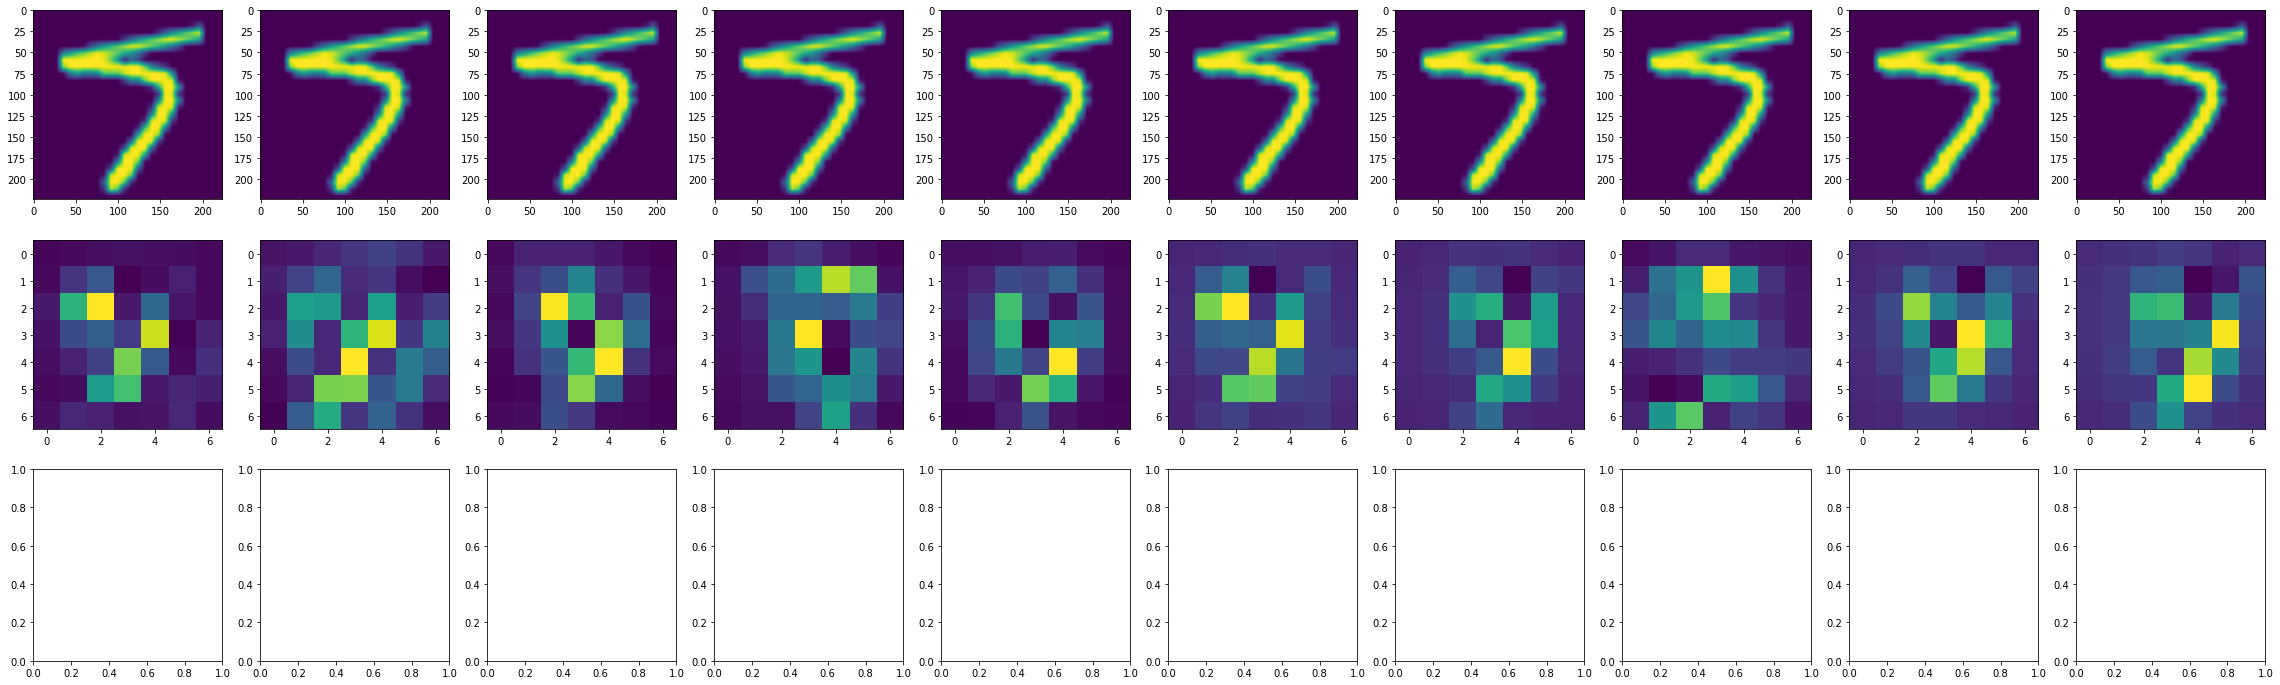

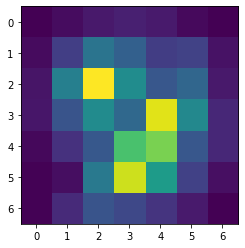

In [11]:
k=10

img_line, _ = dataset_line[17]

signals = pn(run_through_lcl(model, img_line))
signals = signals.reshape((512,7,7))

vals, inds, = torch.topk(torch.sum(signals, dim=(-2,-1)), k)

fig, axs = plt.subplots(3, k, figsize=(k*4, 3*4))

for i in range(k):
    axs[0, i].imshow(img_line.transpose(1,2).transpose(0,2).cpu())
    axs[1, i].imshow(signals[inds[i], :, :].detach().numpy())
    
plt.show()
plt.imshow(torch.sum(signals[inds], dim=0).detach())
    